## In this tutorial: 
- how to loop over axes and data 
- how to display axis labels only in some axes 
- how to store styles in dictionaries 
- how to adjust tick frequency 
- how to create a custom legend 
- how to pass properties inside a charting function 

Small multiples is an extremely helpful technique in data visualization. See below [how a small multiples chart can be done using seaborn's `relplot`](https://seaborn.pydata.org/examples/timeseries_facets.html). How could we make such a chart from scratch in MPL, adjusted to our needs? 

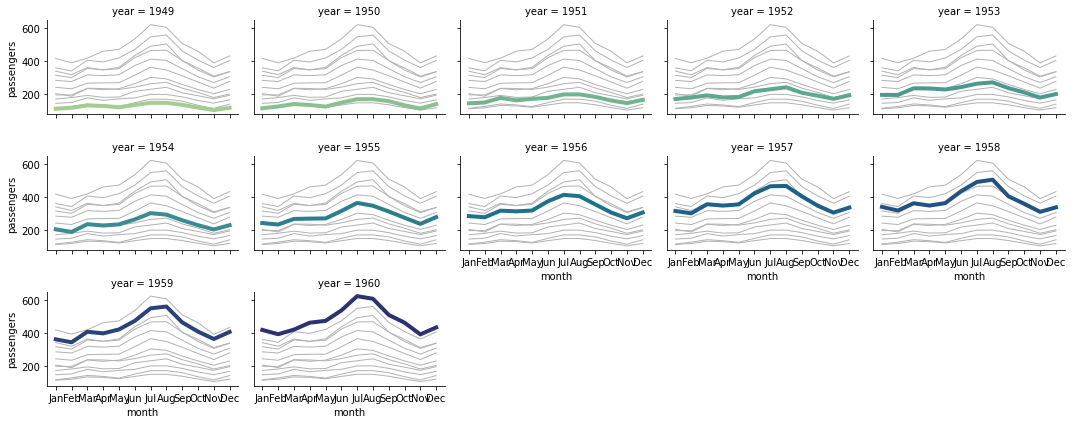

In [1]:
import seaborn as sns

flights = sns.load_dataset("flights")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=flights,
    x="month", y="passengers", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():
    
    # Plot every year's time series in the background
    sns.lineplot(
        data=flights, x="month", y="passengers", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

g.tight_layout()

## Step 1: read and pre-transform the data

Let's read in dummy data and preprocess the datetimes, so that we can easily plot: 

In [2]:
from seaborn import load_dataset
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np

df = load_dataset('flights')
df['m'] = df['month'].cat.codes.apply(lambda x: x+1)
df = df.sort_values(by=['year','m'])

## Step 2: create a small-multiples skeleton

We want to create a small multiples chart, one chart per year. 

Let's start from defining the rows and columns in the grid manually. We can use `plt.subplots()` and then iterate over the axes and the sub-dataframe for each axes. For this, we're going to `zip` the axes and the keys used to sub-sample the dataframe. 

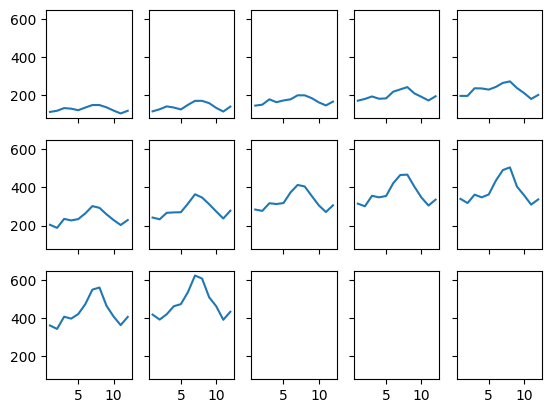

In [3]:
f, axes = plt.subplots(ncols=5, nrows=3, sharex=True, sharey=True)

for chosen, ax in zip(df['year'].unique(), axes.ravel()): 
    tmp_df = df[df['year']==chosen]
    ax.plot(tmp_df['m'], tmp_df['passengers'], )

Bummer: `zip` will stop evaluating the moment the shorter list is exhausted.  

However, we can use a [`zip_longest` function from `itertools`](https://docs.python.org/3/library/itertools.html#itertools.zip_longest) which will iterate until it exhausts the longer list. If we don't provide a `fillvalue` to it, it will produce `None` once the shorter iterable has been exhausted. E.g.  

In [4]:
from itertools import zip_longest

In [5]:
for first, second in zip_longest(range(3), range(5)):
    print(first, second)

0 0
1 1
2 2
None 3
None 4


We need to generate more or equal axes than the number of charts we effectively expect (i.e. in our example, the number of available years). Then whenever we get `None` for the year, we can remove the axis from the figure: 

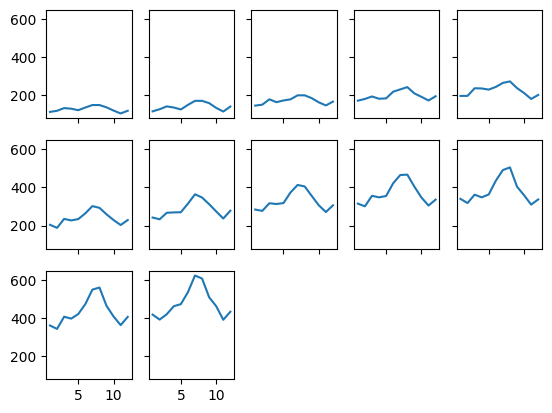

In [6]:
f, axes = plt.subplots(ncols=5, nrows=3, sharex=True, sharey=True)

for chosen, ax in zip_longest(df['year'].unique(), axes.ravel()): 
    if chosen is not None:
        tmp_df = df[df['year']==chosen]
        ax.plot(tmp_df['m'], tmp_df['passengers'], )
    else: 
#         ax.axis('off')
        ax.remove()

Looks good! 

Only the last adjustment: until now we have defined the number of charts by hand. Let's only define the number of columns and let the script handle the relevant number of rows. Also, let's not hardcode our column name, but rather store it in a variable: 

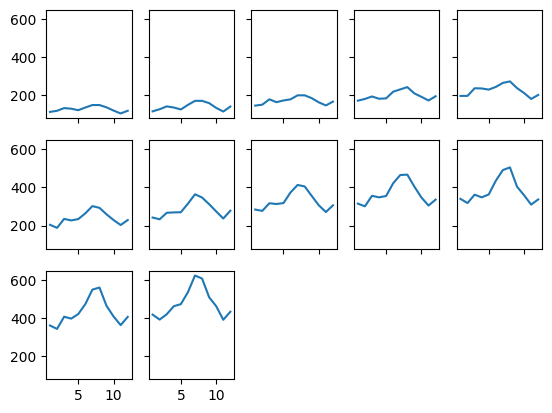

In [7]:
col = 'year'
num_cols = 5

num_rows = (df[col].nunique() // num_cols) + 1

f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)

for chosen, ax in zip_longest(df[col].unique(), axes.ravel()): 
    if chosen is not None:
        tmp_df = df[df[col]==chosen]
        ax.plot(tmp_df['m'], tmp_df['passengers'], )
    else: 
        ax.remove()    

## Step 3: add missing x-labels

Another problem has arisen. Because we are using `sharex`, `sharey`, the labels on the bottom line of charts are missing. Let's find out which charts are on the bottom. We will create a bool table where we define 1 for the charts where we want to see the xlabels: 

In [8]:
remaining =  df[col].nunique() % num_cols 

is_xlabeled = np.zeros((num_rows, num_cols))
is_xlabeled[-1][0:remaining] = 1
is_xlabeled[-2][remaining:] = 1

In [9]:
is_xlabeled

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1.],
       [1., 1., 0., 0., 0.]])

Now I can integrate it in my code by adding it to the `zip_longest`: 

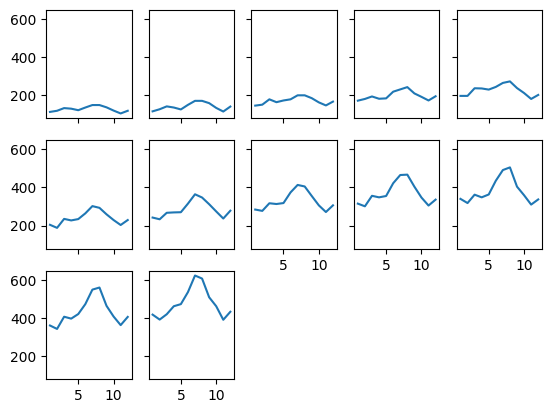

In [10]:
col = 'year'
num_cols = 5

num_charts = df[col].nunique()

num_rows = (num_charts // num_cols) + 1
remaining =  num_charts % num_cols 

is_xlabeled = np.zeros((num_rows, num_cols))
is_xlabeled[-1][0:remaining] = 1
is_xlabeled[-2][remaining:] = 1

f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)

for chosen, ax, xlab in zip_longest(df[col].unique(), axes.ravel(), is_xlabeled.ravel()): 
    if chosen is not None:
        tmp_df = df[df[col]==chosen]
        ax.plot(tmp_df['m'], tmp_df['passengers'], )
        if xlab: 
            ax.tick_params(axis='x', which='major', labelbottom=True)
    else: 
        ax.remove()    


However, I don't like it for the readability. Also, maybe I don't want to have this option hardcoded - it will be easier to parametrize it if I add the labels in a second loop. Here I can use a simple `zip`, because the `is_xlabeled` and `axes` have the same shapes. 

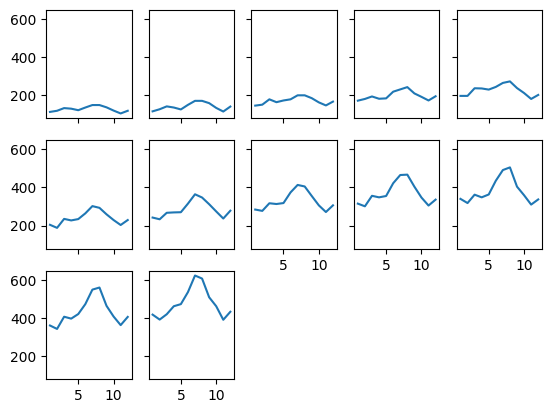

In [11]:
col = 'year'
num_cols = 5

num_charts = df[col].nunique()

num_rows = (num_charts // num_cols) + 1
remaining =  num_charts % num_cols 

is_xlabeled = np.zeros((num_rows, num_cols))
is_xlabeled[-1][0:remaining] = 1
is_xlabeled[-2][remaining:] = 1

f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)

for chosen, ax in zip_longest(df[col].unique(), axes.ravel()): 
    if chosen is not None:
        tmp_df = df[df[col]==chosen]
        ax.plot(tmp_df['m'], tmp_df['passengers'], )
    else: 
        ax.remove()    

for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
    if xlab: 
        ax.tick_params(axis='x', which='major', labelbottom=True)
    

Looks good! 

## Step 4: add the data in the background

For this, let's reshape our data. It's going to be easier if we take advantage of the long-wide conversion and create a pivot table containing our data. Here we don't need to do any aggregation, but this would be the first step in a data prep pipeline. 

In [12]:
df_pivot = df.pivot(index='m', columns=col, values='passengers')

In [13]:
df_pivot

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
m,,,,,,,,,,,,
1,112,115,145,171,196,204,242,284,315,340,360,417
2,118,126,150,180,196,188,233,277,301,318,342,391
3,132,141,178,193,236,235,267,317,356,362,406,419
4,129,135,163,181,235,227,269,313,348,348,396,461
5,121,125,172,183,229,234,270,318,355,363,420,472
6,135,149,178,218,243,264,315,374,422,435,472,535
7,148,170,199,230,264,302,364,413,465,491,548,622
8,148,170,199,242,272,293,347,405,467,505,559,606
9,136,158,184,209,237,259,312,355,404,404,463,508


Now I can refactor the code: I can use `df_pivot` for getting my selected curve and for getting the background curves:  

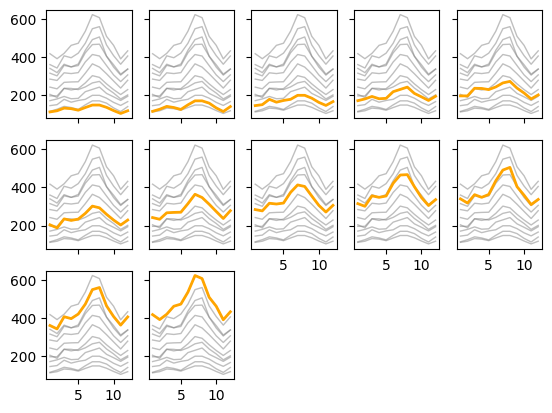

In [14]:
col = 'year'
num_cols = 5

num_charts = df[col].nunique()

num_rows = (num_charts // num_cols) + 1
remaining =  num_charts % num_cols 

is_xlabeled = np.zeros((num_rows, num_cols))
is_xlabeled[-1][0:remaining] = 1
is_xlabeled[-2][remaining:] = 1

f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)
df_pivot = df.pivot(index='m', columns=col, values='passengers')

for chosen, ax in zip_longest(df[col].unique(), axes.ravel()): 
    if chosen is not None:
        tmp_df = df_pivot[chosen]
        ax.plot(tmp_df, color='orange', lw=2, zorder=99)
        ax.plot(df_pivot, color='gray', lw=1, alpha=0.5)
    else: 
        ax.remove()    

for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
    if xlab: 
        ax.tick_params(axis='x', which='major', labelbottom=True)
    

Let's move the styling outside of the loop where we plotting the dashboard. Maybe in the future we want to try out various colors and build up a legend basing on those colors. Dictionary is great for this: 

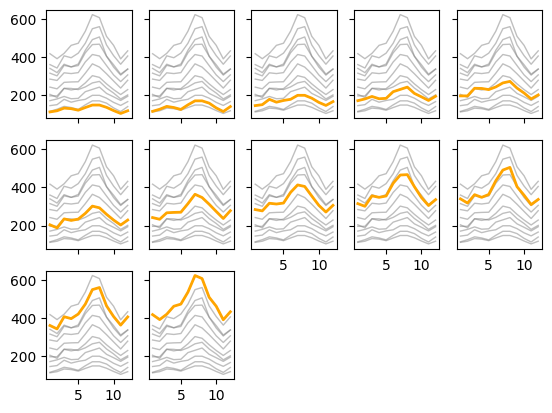

In [15]:
col = 'year'
num_cols = 5

style_selected = {'color': 'orange', 'lw': 2, 'zorder': 99}
style_bg = {'color': 'gray', 'lw': 1, 'alpha': 0.5}

num_charts = df[col].nunique()

num_rows = (num_charts // num_cols) + 1
remaining =  num_charts % num_cols 

is_xlabeled = np.zeros((num_rows, num_cols))
is_xlabeled[-1][0:remaining] = 1
is_xlabeled[-2][remaining:] = 1

f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)
df_pivot = df.pivot(index='m', columns=col, values='passengers')

for chosen, ax in zip_longest(df[col].unique(), axes.ravel()): 
    if chosen is not None:
        tmp_df = df_pivot[chosen]
        ax.plot(tmp_df, **style_selected)
        ax.plot(df_pivot, **style_bg)
    else: 
        ax.remove()    

for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
    if xlab: 
        ax.tick_params(axis='x', which='major', labelbottom=True)
    

Also, let's not use hardcoded values for x,y values and only use df_pivot from now on. 

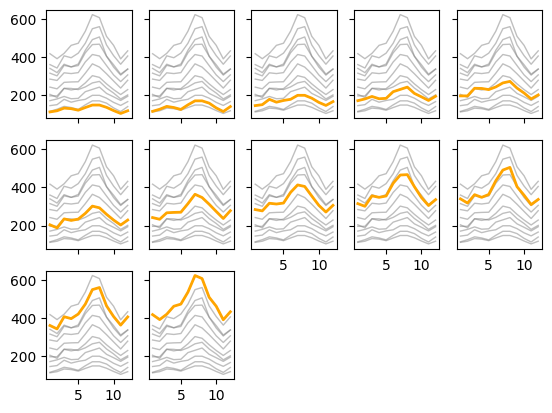

In [16]:
col = 'year'
x_col = 'm'
y_col = 'passengers'
num_cols = 5

style_selected = {'color': 'orange', 'lw': 2, 'zorder': 99}
style_bg = {'color': 'gray', 'lw': 1, 'alpha': 0.5}

df_pivot = df.pivot(index=x_col, columns=col, values=y_col)

num_charts = len(df_pivot.columns)
num_rows = (num_charts // num_cols) + 1
remaining =  num_charts % num_cols 

is_xlabeled = np.zeros((num_rows, num_cols))
is_xlabeled[-1][0:remaining] = 1
is_xlabeled[-2][remaining:] = 1

f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)

for chosen, ax in zip_longest(df_pivot.columns, axes.ravel()): 
    if chosen is not None:
        tmp_df = df_pivot[chosen]
        ax.plot(tmp_df, **style_selected)
        ax.plot(df_pivot, **style_bg)
    else: 
        ax.remove()    

for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
    if xlab: 
        ax.tick_params(axis='x', which='major', labelbottom=True)
    

Now it looks like we have separated the data and plotting parts. We can wrap our code in a function. We define default styles inside the function, and return `f` and `axes` objects for easy modification further on.  

In [17]:
def small_multiples(df, col, x_col, y_col, num_cols, 
                    style_selected = None, style_bg = None):
    
    if style_selected is None: 
        style_selected = {'color': 'orange', 'lw': 2, 'zorder': 99}
    if style_bg is None:
        style_bg = {'color': 'gray', 'lw': 1, 'alpha': 0.5}

    df_pivot = df.pivot(index=x_col, columns=col, values=y_col)

    num_charts = len(df_pivot.columns)
    num_rows = (num_charts // num_cols) + 1
    remaining =  num_charts % num_cols 

    is_xlabeled = np.zeros((num_rows, num_cols))
    is_xlabeled[-1][0:remaining] = 1
    is_xlabeled[-2][remaining:] = 1

    f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, sharey=True)

    for chosen, ax in zip_longest(df_pivot.columns, axes.ravel()): 
        if chosen is not None:
            tmp_df = df_pivot[chosen]
            ax.plot(tmp_df, **style_selected)
            ax.plot(df_pivot, **style_bg)
        else: 
            ax.remove()    

    for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
        if xlab: 
            ax.tick_params(axis='x', which='major', labelbottom=True)

    return f, axes

With such a structure, we can easily modify the look and feel of our small-multiples dashboard: 

Text(0.5, 0.98, 'Flights over the years')

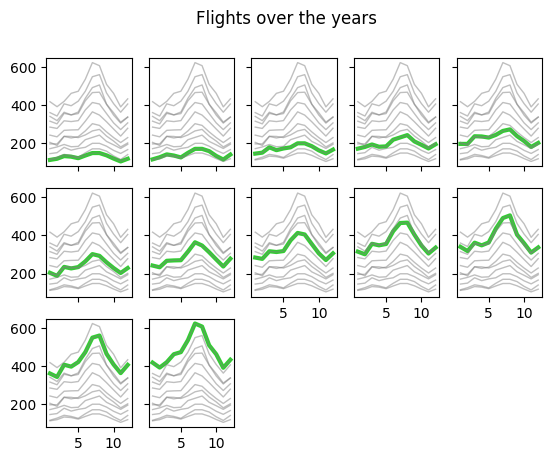

In [18]:
f, axes = small_multiples(df=df, col='year', x_col='m', y_col='passengers', 
                          num_cols=5, 
                          style_selected={'color':'limegreen', 'lw':3},)

f.suptitle('Flights over the years')

However, there is something we are missing. We cannot easily scale the size of the dashboard. For this, let's declare another variable `dashboard_props`, which we will pass to `plt.subplots()`: 

In [19]:
def small_multiples(df, col, x_col, y_col, num_cols, 
                    style_selected = None, style_bg = None, 
                    dashboard_props = None):
    
    if style_selected is None: 
        style_selected = {'color': 'orange', 'lw': 2, 'zorder': 99}
    if style_bg is None:
        style_bg = {'color': 'gray', 'lw': 1, 'alpha': 0.5}
        
    if dashboard_props is None:
        dashboard_props = {}
        
    df_pivot = df.pivot(index=x_col, columns=col, values=y_col)

    num_charts = len(df_pivot.columns)
    num_rows = (num_charts // num_cols) + 1
    remaining =  num_charts % num_cols 

    is_xlabeled = np.zeros((num_rows, num_cols))
    is_xlabeled[-1][0:remaining] = 1
    is_xlabeled[-2][remaining:] = 1

    f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, 
                           sharex=True, sharey=True, 
                           **dashboard_props)

    for chosen, ax in zip_longest(df_pivot.columns, axes.ravel()): 
        if chosen is not None:
            tmp_df = df_pivot[chosen]
            ax.plot(tmp_df, **style_selected)
            ax.plot(df_pivot, **style_bg)
        else: 
            ax.remove()    

    for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
        if xlab: 
            ax.tick_params(axis='x', which='major', labelbottom=True)

    
    return f, axes

Now we can also make x-ticks a bit more human-friendly. With the current structure, it is easy to do without having to modify the base function: 

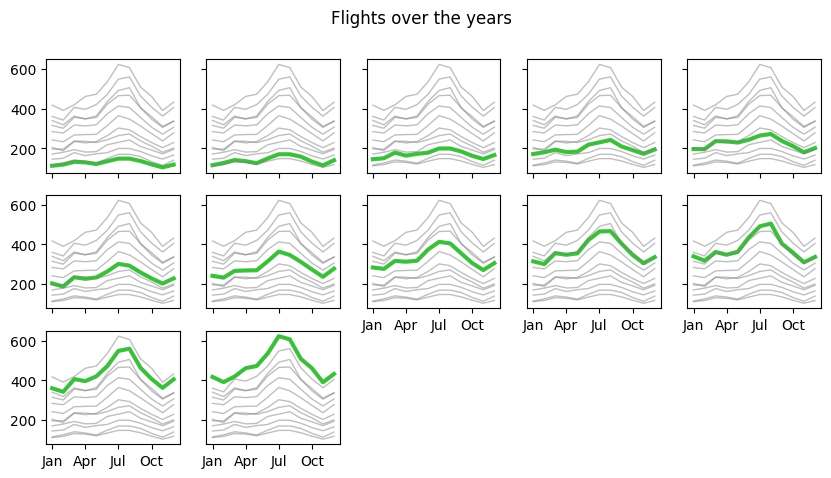

In [20]:
f, axes = small_multiples(df=df, col='year', x_col='month', y_col='passengers', 
                          num_cols=5, 
                          style_selected={'color':'limegreen', 'lw':3},
                         dashboard_props={'figsize': (10,5)})

f.suptitle('Flights over the years')

from matplotlib.ticker import MultipleLocator
[ax.xaxis.set_major_locator(MultipleLocator(3)) for ax in axes.ravel()];

## Step 5: legend and annotations

Let's add annotations: at this point there is no information about the actual year! 

In [21]:
def small_multiples(df, col, x_col, y_col, num_cols, 
                    style_selected = None, style_bg = None, 
                    dashboard_props = None, text_props = None):
    
    if style_selected is None: 
        style_selected = {'color': 'orange', 'lw': 2, 'zorder': 99}
    if style_bg is None:
        style_bg = {'color': 'gray', 'lw': 1, 'alpha': 0.5}
        
    if dashboard_props is None:
        dashboard_props = {}
        
    default_text_props = {'x': 0.95, 'y': 0.95}
    if text_props is None: 
        text_props = {}
    if 'x' not in text_props.keys(): 
        text_props['x'] = default_text_props['x']
    if 'y' not in text_props.keys(): 
        text_props['y'] = default_text_props['y']
        
    df_pivot = df.pivot(index=x_col, columns=col, values=y_col)

    num_charts = len(df_pivot.columns)
    num_rows = (num_charts // num_cols) + 1
    remaining =  num_charts % num_cols 

    is_xlabeled = np.zeros((num_rows, num_cols))
    is_xlabeled[-1][0:remaining] = 1
    is_xlabeled[-2][remaining:] = 1

    f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, 
                           sharex=True, sharey=True, 
                           **dashboard_props)

    for chosen, ax in zip_longest(df_pivot.columns, axes.ravel()): 
        if chosen is not None:
            tmp_df = df_pivot[chosen]
            ax.plot(tmp_df, **style_selected)
            ax.plot(df_pivot, **style_bg)
            ax.text(s=chosen, 
                transform=ax.transAxes, 
                va='top', ha='right', zorder=1, 
                   **text_props)
        else: 
            ax.remove()    

    for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
        if xlab: 
            ax.tick_params(axis='x', which='major', labelbottom=True)

    
    return f, axes

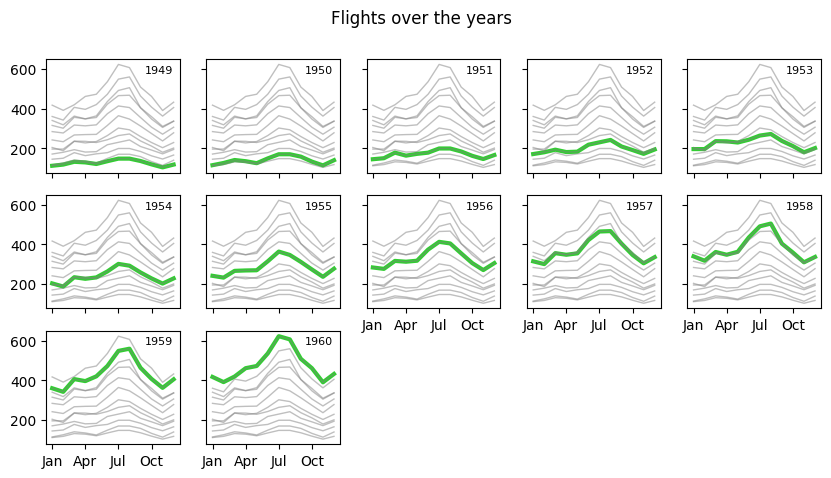

In [22]:
f, axes = small_multiples(df=df, col='year', x_col='month', y_col='passengers', 
                          num_cols=5, 
                          style_selected={'color':'limegreen', 'lw':3},
                         dashboard_props={'figsize': (10,5)}, text_props={'size':8})

f.suptitle('Flights over the years')

from matplotlib.ticker import MultipleLocator
[ax.xaxis.set_major_locator(MultipleLocator(3)) for ax in axes.ravel()];

And let's add a legend: 

In [23]:
def small_multiples(df, col, x_col, y_col, num_cols, 
                    style_selected = None, style_bg = None, 
                    dashboard_props = None, text_props = None):
    
    if style_selected is None: 
        style_selected = {'color': 'orange', 'lw': 2, 'zorder': 99}
    if style_bg is None:
        style_bg = {'color': 'gray', 'lw': 1, 'alpha': 0.5}
        
    if dashboard_props is None:
        dashboard_props = {}
        
    default_text_props = {'x': 0.95, 'y': 0.95}
    if text_props is None: 
        text_props = {}
    if 'x' not in text_props.keys(): 
        text_props['x'] = default_text_props['x']
    if 'y' not in text_props.keys(): 
        text_props['y'] = default_text_props['y']
        
    df_pivot = df.pivot(index=x_col, columns=col, values=y_col)

    num_charts = len(df_pivot.columns)
    num_rows = (num_charts // num_cols) + 1
    remaining =  num_charts % num_cols 

    is_xlabeled = np.zeros((num_rows, num_cols))
    is_xlabeled[-1][0:remaining] = 1
    is_xlabeled[-2][remaining:] = 1

    f, axes = plt.subplots(ncols=num_cols, nrows=num_rows, 
                           sharex=True, sharey=True, 
                           **dashboard_props)

    for chosen, ax in zip_longest(df_pivot.columns, axes.ravel()): 
        if chosen is not None:
            tmp_df = df_pivot[chosen]
            ax.plot(tmp_df, **style_selected)
            ax.plot(df_pivot, **style_bg)
            ax.text(s=chosen, 
                transform=ax.transAxes, 
                va='top', ha='right', zorder=1, 
                   **text_props)
        else: 
            ax.remove()    

    for xlab, ax in zip(is_xlabeled.ravel(), axes.ravel()): 
        if xlab: 
            ax.tick_params(axis='x', which='major', labelbottom=True)
    
    from matplotlib.lines import Line2D
    labels = ['selected year', 'other years']
    handles = [Line2D([0], [0], **style_selected), Line2D([0], [0], **style_bg)]
    
    axes.ravel()[num_charts-1]\
        .legend(labels=labels, handles=handles,
              bbox_to_anchor=[1.25,0.5], loc='center left', 
              edgecolor='white', facecolor='white',
              borderpad=0, borderaxespad=0)
    
    return f, axes

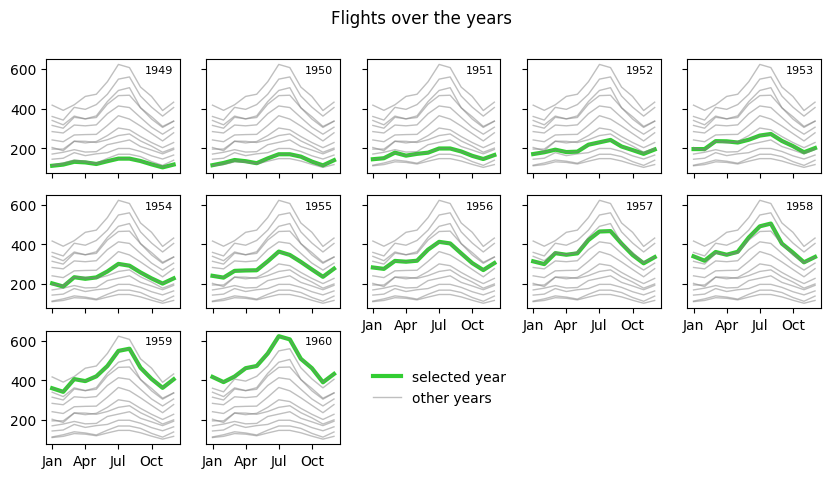

In [24]:
f, axes = small_multiples(df=df, col='year', x_col='month', y_col='passengers', 
                          num_cols=5, 
                          style_selected={'color':'limegreen', 'lw':3},
                         dashboard_props={'figsize': (10,5)}, text_props={'size':8})

f.suptitle('Flights over the years')

from matplotlib.ticker import MultipleLocator
[ax.xaxis.set_major_locator(MultipleLocator(3)) for ax in axes.ravel()];